In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from os.path import join
from IPython.display import clear_output

In [2]:
# Download example data
!sct_download_data -d sct_example_data

# Go to MT folder
os.chdir('sct_example_data/mt/')


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_download_data.py -d sct_example_data

Trying URL: https://osf.io/kjcgs/?action=download
Status: 100%|##############################| 44.3M/44.3M [00:01<00:00, 22.2MB/s]

Check if folder already exists...
rm -rf sct_example_data

Unzip data to: /home/jovyan/work/binder-example

Remove temporary file...
Done!

Total processing time: 0 min 9 s



In [3]:
# Jupyter Notebook config
verbose = True # False clears cells

# Folder/filename config
mt_folder = 'sct_example_data/mt'
qc_folder ='qc'

t1w = 't1w'
mt0 = 'mt0'
mt1 = 'mt1'
label_c3c4 = 'label_c3c4'
warp_template2anat = 'warp_template2anat'
mtr = 'mtr'
mtsat = 'mtsat'
t1map = 't1map'

file_ext = '.nii.gz'

# Ouputs
results_filename = 'results.csv'

if not verbose:
    clear_output()

In [4]:
# Segment spinal cord
!MPLBACKEND=agg sct_deepseg_sc -i {t1w+file_ext} -c t1 -qc {qc_folder}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_deepseg_sc.py -i t1w.nii.gz -c t1 -qc qc

Method:
	Centerline algorithm: svm
	Assumes brain section included in the image: True
	Dimension of the segmentation kernel convolutions: 2d

Creating temporary folder...
Reorient the image to RPI, if necessary...
Finding the spinal cord centerline...
Resample the image to 0.5 mm isotropic resolution...
/home/jovyan/work/binder-example/sct/python/lib/python2.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)
Cropping the image around the spinal cord...
Normalizing the intensity...
Segmenting the spinal cord using deep learning on 2D patches...
Reassembling the image...
Resampling the segmentation to the original image resolution...
Binarizing the segmentation to avoid interpolati

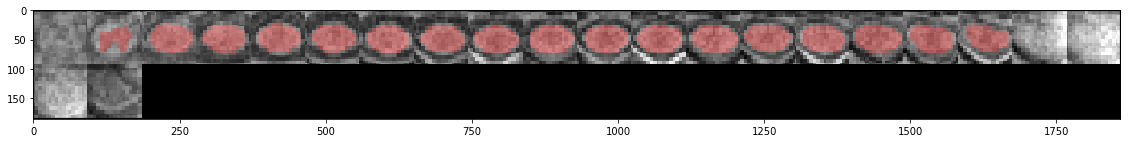

In [5]:

sct_deepseg_sc_qc = join(qc_folder, mt_folder, 'sct_deepseg_sc')
folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_deepseg_sc_qc, x)), os.listdir(sct_deepseg_sc_qc)))
qc_date = max(folders)

sct_deepseg_sc_qc_dir = join(sct_deepseg_sc_qc, qc_date)

bkg=mpimg.imread(join(sct_deepseg_sc_qc_dir, 'bkg_img.png'))
overlay=mpimg.imread(join(sct_deepseg_sc_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

In [6]:
# Create mask
!sct_create_mask -i {t1w+file_ext} -p centerline,{t1w+'_seg'+file_ext} -size 35mm -o {t1w+'_mask'+file_ext}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_create_mask.py -i t1w.nii.gz -p centerline,t1w_seg.nii.gz -size 35mm -o t1w_mask.nii.gz
  OK: t1w_seg.nii.gz

Create temporary folder (/tmp/sct-20190227234708.945306-create_mask-g0FJR_)...

Orientation:
  LPI

Dimensions:
(192, 192, 22, 1, 0.89583331, 0.89583331, 5.000001, 1)

Create mask...

Remove temporary files...
rm -rf /tmp/sct-20190227234708.945306-create_mask-g0FJR_
Total processing time: 0 min 6 s



In [7]:
# Crop data for faster processing
!sct_crop_image -i {t1w+file_ext} -m {t1w+'_mask'+file_ext} -o {t1w+'_crop'+file_ext}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_crop_image.py -i t1w.nii.gz -m t1w_mask.nii.gz -o t1w_crop.nii.gz
isct_crop_image -i t1w.nii.gz -o t1w_crop.nii.gz -start 73,70,4 -end 118,111,20 -dim 0,1,2 # in /home/jovyan/work/binder-example/sct_example_data/mt
Cropping the following region:
Dimension 0: 73 118
Dimension 1: 70 111
Dimension 2: 4 20
Total processing time: 0 min 4 s



In [8]:
# Register PD->T1w
# Tips: here we only use rigid transformation because both images have very similar sequence parameters. We don't want to use SyN/BSplineSyN to avoid introducing spurious deformations.
!sct_register_multimodal -i {mt0+file_ext} -d {t1w+'_crop'+file_ext} -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline

# Register MT->T1w
!sct_register_multimodal -i {mt1+file_ext} -d {t1w+'_crop'+file_ext} -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_register_multimodal.py -i mt0.nii.gz -d t1w_crop.nii.gz -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline

Input parameters:
  Source .............. mt0.nii.gz
  Destination ......... t1w_crop.nii.gz
  Init transfo ........ 
  Mask ................ 
  Output name ......... 
  Remove temp files ... 1
  Verbose ............. 1

Check if input data are 3D...

Create temporary folder (/tmp/sct-20190227234729.170616-WKh8sH)...

Copying input data to tmp folder and convert to nii...

--
ESTIMATE TRANSFORMATION FOR STEP #0
Registration parameters:
  type ........... im
  algo ........... syn
  slicewise ...... 0
  metric ......... MI
  iter ........... 0
  smooth ......... 0
  laplacian ...... 0
  shrink ......... 1
  gradStep ....... 0.5
  deformation .... 1x1x0
  init ........... 
  poly ........... 5
  dof ............ Tx_Ty_Tz_Rx_Ry_Rz
  smoothW

In [9]:
# Create label 4 at the mid-FOV, because we know the FOV is centered at C3-C4 disc.
!sct_label_utils -i {t1w+'_seg'+file_ext} -create-seg -1,4 -o {label_c3c4+file_ext}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_label_utils.py -i t1w_seg.nii.gz -create-seg -1,4 -o label_c3c4.nii.gz
Label #4: 94,92,11 --> 4
Total processing time: 0 min 5 s



In [10]:
# Register template->T1w_ax (using template-T1w as initial transformation)
!MPLBACKEND=agg sct_register_to_template -i {t1w+'_crop'+file_ext} -s {t1w+'_seg'+file_ext} -ldisc {label_c3c4+file_ext} -ref subject -c t1 -param step=1,type=seg,algo=slicereg,metric=MeanSquares,smooth=2:step=2,type=im,algo=bsplinesyn,metric=MeanSquares,iter=5,gradStep=0.5 -qc {qc_folder}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_register_to_template.py -i t1w_crop.nii.gz -s t1w_seg.nii.gz -ldisc label_c3c4.nii.gz -ref subject -c t1 -param step=1,type=seg,algo=slicereg,metric=MeanSquares,smooth=2:step=2,type=im,algo=bsplinesyn,metric=MeanSquares,iter=5,gradStep=0.5 -qc qc
Folder qc has been created.

Check template files...
  OK: /home/jovyan/work/binder-example/sct/data/PAM50/template/PAM50_t1.nii.gz
  OK: /home/jovyan/work/binder-example/sct/data/PAM50/template/PAM50_levels.nii.gz
  OK: /home/jovyan/work/binder-example/sct/data/PAM50/template/PAM50_cord.nii.gz

Check parameters:
  Data:                 t1w_crop.nii.gz
  Landmarks:            label_c3c4.nii.gz
  Segmentation:         t1w_seg.nii.gz
  Path template:        /home/jovyan/work/binder-example/sct/data/PAM50
  Remove temp files:    0

Check input labels...

Create temporary folder (/tmp/sct-20190227235032.004330-register

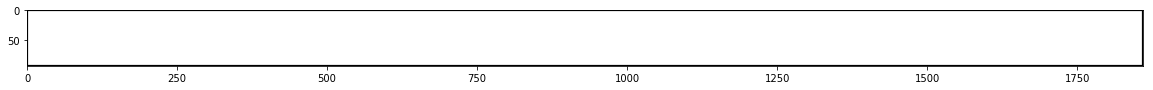

In [11]:
sct_register_to_template_qc = join(qc_folder, mt_folder, 'sct_register_to_template')
folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_register_to_template_qc, x)), os.listdir(sct_register_to_template_qc)))
qc_date = max(folders)

sct_register_to_template_qc_dir = join(sct_register_to_template_qc, qc_date)

bkg=mpimg.imread(join(sct_register_to_template_qc_dir, 'bkg_img.png'))
overlay=mpimg.imread(join(sct_register_to_template_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

In [12]:
# Warp template
!MPLBACKEND=agg sct_warp_template -d {t1w+'_crop'+file_ext} -w {warp_template2anat+file_ext} -qc {qc_folder}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_warp_template.py -d t1w_crop.nii.gz -w warp_template2anat.nii.gz -qc qc
Folder qc has been created.

Check parameters:
  Working directory ........ /home/jovyan/work/binder-example/sct_example_data/mt
  Destination image ........ t1w_crop.nii.gz
  Warping field ............ warp_template2anat.nii.gz
  Path template ............ /home/jovyan/work/binder-example/sct/data/PAM50
  Output folder ............ label


WARP TEMPLATE:

Read label file...
sct_apply_transfo -i /home/jovyan/work/binder-example/sct/data/PAM50/template/PAM50_t1.nii.gz -o label/template/PAM50_t1.nii.gz -d t1w_crop.nii.gz -w warp_template2anat.nii.gz -x linear # in /home/jovyan/work/binder-example/sct_example_data/mt
sct_apply_transfo -i /home/jovyan/work/binder-example/sct/data/PAM50/template/PAM50_t2.nii.gz -o label/template/PAM50_t2.nii.gz -d t1w_crop.nii.gz -w warp_template2anat.nii.gz

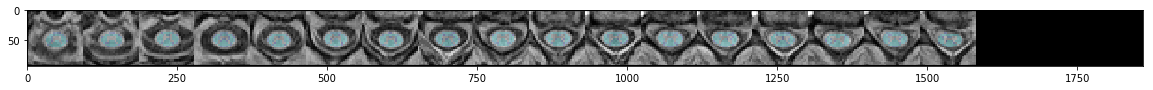

In [13]:
sct_warp_template_qc = join(qc_folder, mt_folder, 'sct_warp_template')
folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_warp_template_qc, x)), os.listdir(sct_warp_template_qc)))
qc_date = max(folders)

sct_warp_template_qc_dir = join(sct_warp_template_qc, qc_date)

bkg=mpimg.imread(join(sct_warp_template_qc_dir, 'bkg_img.png'))
overlay=mpimg.imread(join(sct_warp_template_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

In [14]:
# Compute MTR
!sct_compute_mtr -mt1 {mt1+'_reg'+file_ext} -mt0 {mt0+'_reg'+file_ext}

# Compute MTsat and T1
!sct_compute_mtsat -mt {mt1+'_reg'+file_ext} -pd {mt0+'_reg'+file_ext} -t1 {t1w+'_crop'+file_ext} -trmt 57 -trpd 57 -trt1 15 -famt 9 -fapd 9 -fat1 15

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_compute_mtr.py -mt1 mt1_reg.nii.gz -mt0 mt0_reg.nii.gz

Create temporary folder (/tmp/sct-20190228001305.849307-MxMALe)...

Copying input data to tmp folder and convert to nii...
sct_convert -i mt0_reg.nii.gz -o /tmp/sct-20190228001305.849307-MxMALe/mt0.nii
sct_convert -i mt1_reg.nii.gz -o /tmp/sct-20190228001305.849307-MxMALe/mt1.nii

Compute MTR...

Generate output files...
sct_convert -i /tmp/sct-20190228001305.849307-MxMALe/mtr.nii -o mtr.nii.gz
  File created: mtr.nii.gz

Remove temporary files...
rm -rf /tmp/sct-20190228001305.849307-MxMALe
Total processing time: 0 min 3 s


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_compute_mtsat.py -mt mt1_reg.nii.gz -pd mt0_reg.nii.gz -t1 t1w_crop.nii.gz -trmt 57 -trpd 57 -trt1 15 -famt 9 -fapd 9 -fat1 15
Load data...
Compute T1 

In [15]:
# Extract MTR, MTsat and T1 in WM between C2 and C4 vertebral levels
!sct_extract_metric -i mtr.nii.gz -l 51 -vert 2:4 -o {results_filename}
!sct_extract_metric -i mtsat.nii.gz -l 51 -vert 2:4 -o {results_filename} -append 1
!sct_extract_metric -i t1map.nii.gz -l 51 -vert 2:4 -o {results_filename} -append 1



--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_extract_metric.py -i mtr.nii.gz -l 51 -vert 2:4 -o results.csv

Load metric image...
Estimation for label: white matter

File created: results.csv
Total processing time: 0 min 4 s


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_extract_metric.py -i mtsat.nii.gz -l 51 -vert 2:4 -o results.csv -append 1

Load metric image...
Estimation for label: white matter

File created: results.csv
Total processing time: 0 min 5 s


--
Spinal Cord Toolbox (master/fc2fc50f2061b1046ec53376fa371da014b5ac46)
Running /home/jovyan/work/binder-example/sct/scripts/sct_extract_metric.py -i t1map.nii.gz -l 51 -vert 2:4 -o results.csv -append 1

Load metric image...
Estimation for label: white matter

File created: results.csv
Total processing time: 0 min 5 s

